https://colab.research.google.com/github/zaidalyafeai/Notebooks/blob/master/unet.ipynb#scrollTo=_MXGinNg9Wjj

In [ ]:
!pip install pydotplus

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/My Drive/이미지 분리/

/content/drive/My Drive/이미지 분리


In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annota

https://paperswithcode.com/datasets

Generators

In [13]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for f in batch:

        #get the masks. Note that masks are png files 
        mask = Image.open(f'AHP/reserved/Annotations/{f[:-4]}.png')
        mask = np.array(mask.resize((256,256)))

        #preprocess the mask 
        mask[mask >= 2] = 0 
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'AHP/reserved/JPEGImages/{f}').convert('L')
        raw = np.array(raw.resize((256, 256)))
        raw = cv2.equalizeHist(raw)
        kernel = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
        raw = cv2.filter2D(raw,-1,kernel)
        raw = np.stack((raw,)*1, axis=-1)

        # #check the number of channels because some of the images are RGBA or GRAY
        # if len(raw.shape) == 2:
        #   raw = np.stack((raw,)*3, axis=-1)

        # else:
        #   raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)      
    

In [15]:
batch_size = 32

all_files = os.listdir('AHP/reserved/JPEGImages')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [20]:
x, y= next(train_generator)

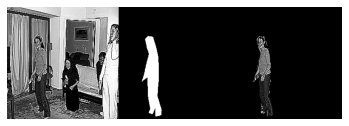

In [18]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
img = img.reshape(256,256)
img = np.stack((img,)*3, axis=-1)
msk = np.stack((msk,)*3, axis=-1)
plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

IoU metric

In [22]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

Model

In [23]:
def unet(sz = (256, 256,3)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D()(x)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model

In [24]:
model = unet(sz=(256,256,1))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 256, 256, 8)  80          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 256, 256, 8)  584         conv2d_27[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 128, 128, 8)  0           conv2d_28[0][0]                  
____________________________________________________________________________________________

Callbacks

In [25]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'AHP/reserved/JPEGImages/{path}').convert('L')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = np.stack((raw,)*1, axis=-1)
        
        #predict the mask   
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze()
        msk = msk.reshape(256,256)
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        raw = raw.reshape(256,256)
        raw = np.stack((raw,)*3, axis=-1)
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

Training

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


i= 1 loss= 0.422584593296051 val_loss= 0.2773433029651642 mean_iou= 0.002424540463835001 val_mean_iou= 0.0


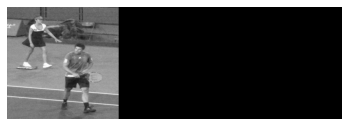

i= 2 loss= 0.2582537531852722 val_loss= 0.23477774858474731 mean_iou= 0.0 val_mean_iou= 0.0


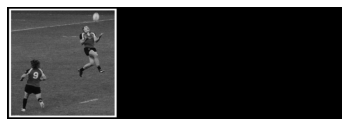

i= 3 loss= 0.24448923766613007 val_loss= 0.21796099841594696 mean_iou= 0.0 val_mean_iou= 0.0


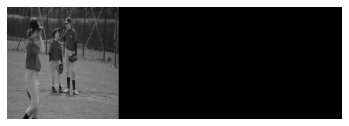

i= 4 loss= 0.2205209881067276 val_loss= 0.25203821063041687 mean_iou= 0.0 val_mean_iou= 0.0


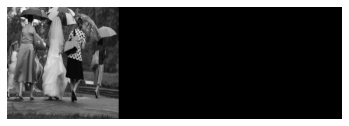

i= 5 loss= 0.22287841141223907 val_loss= 0.19208604097366333 mean_iou= 0.003720602486282587 val_mean_iou= 0.0


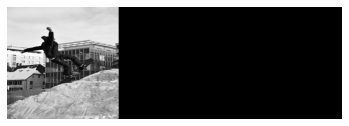

i= 6 loss= 0.21608300507068634 val_loss= 0.22082358598709106 mean_iou= 0.0 val_mean_iou= 0.0


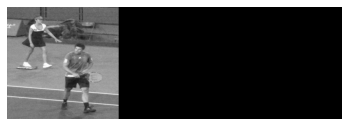

i= 7 loss= 0.2080109566450119 val_loss= 0.18888598680496216 mean_iou= 0.0006695484626106918 val_mean_iou= 0.0


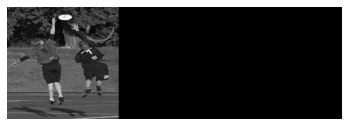

i= 8 loss= 0.2055020034313202 val_loss= 0.20804288983345032 mean_iou= 0.0 val_mean_iou= 0.0


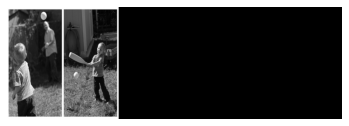

i= 9 loss= 0.2038181722164154 val_loss= 0.23342029750347137 mean_iou= 0.018272578716278076 val_mean_iou= 0.0


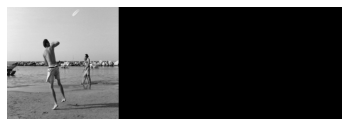

i= 10 loss= 0.19637419283390045 val_loss= 0.2276875525712967 mean_iou= 0.05362042412161827 val_mean_iou= 0.0


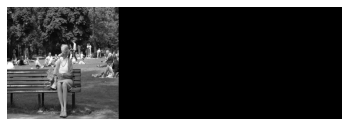

i= 11 loss= 0.19604986906051636 val_loss= 0.16036400198936462 mean_iou= 0.08183152973651886 val_mean_iou= 0.13374996185302734


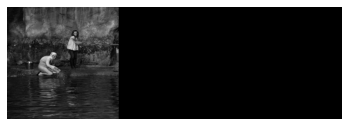

i= 12 loss= 0.17902345955371857 val_loss= 0.16270403563976288 mean_iou= 0.11459445208311081 val_mean_iou= 0.10338550060987473


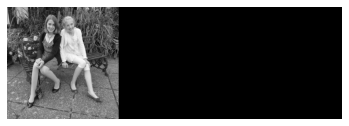

i= 13 loss= 0.17781700193881989 val_loss= 0.1851450502872467 mean_iou= 0.11327922344207764 val_mean_iou= 0.10719246417284012


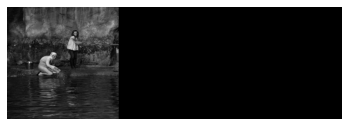

i= 14 loss= 0.1787491738796234 val_loss= 0.12571494281291962 mean_iou= 0.1453697234392166 val_mean_iou= 0.3316495716571808


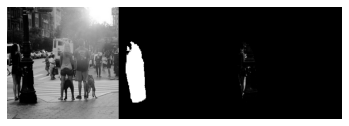

i= 15 loss= 0.1692383587360382 val_loss= 0.19430439174175262 mean_iou= 0.18228304386138916 val_mean_iou= 0.12066691368818283


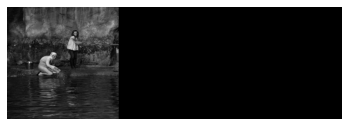

i= 16 loss= 0.17621570825576782 val_loss= 0.21412599086761475 mean_iou= 0.162709578871727 val_mean_iou= 0.13464504480361938


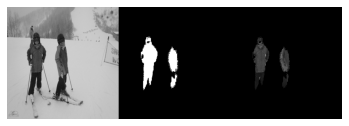

i= 17 loss= 0.16492387652397156 val_loss= 0.15682674944400787 mean_iou= 0.21303969621658325 val_mean_iou= 0.13485629856586456


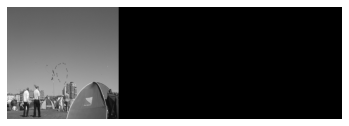

i= 18 loss= 0.16433420777320862 val_loss= 0.15370288491249084 mean_iou= 0.21660949289798737 val_mean_iou= 0.31093403697013855


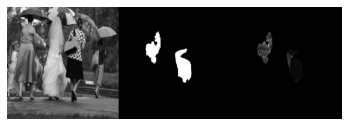

i= 19 loss= 0.16181592643260956 val_loss= 0.17527785897254944 mean_iou= 0.22458764910697937 val_mean_iou= 0.17558234930038452


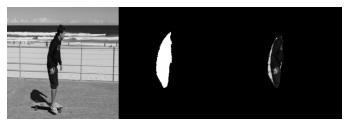

i= 20 loss= 0.16154004633426666 val_loss= 0.12521971762180328 mean_iou= 0.2454901486635208 val_mean_iou= 0.20321336388587952


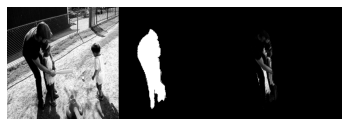

i= 21 loss= 0.15297609567642212 val_loss= 0.13502010703086853 mean_iou= 0.27202120423316956 val_mean_iou= 0.3305302858352661


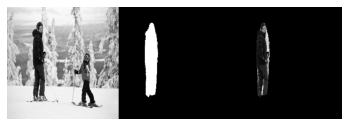

i= 22 loss= 0.15255825221538544 val_loss= 0.12427108734846115 mean_iou= 0.2658727467060089 val_mean_iou= 0.3765016794204712


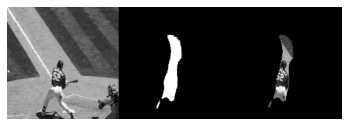

i= 23 loss= 0.14932513236999512 val_loss= 0.16982612013816833 mean_iou= 0.32711851596832275 val_mean_iou= 0.2593684494495392


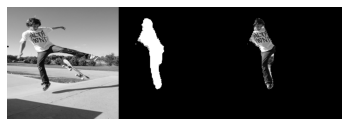

i= 24 loss= 0.13785380125045776 val_loss= 0.1814432144165039 mean_iou= 0.3390888571739197 val_mean_iou= 0.33693650364875793


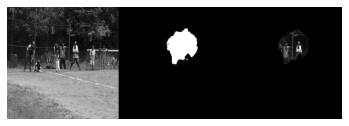

i= 25 loss= 0.14401930570602417 val_loss= 0.1545003205537796 mean_iou= 0.34164878726005554 val_mean_iou= 0.2725784182548523


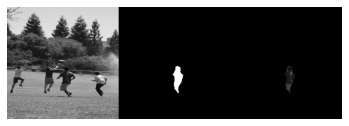

i= 26 loss= 0.1334616243839264 val_loss= 0.1506601870059967 mean_iou= 0.37775248289108276 val_mean_iou= 0.3197205066680908


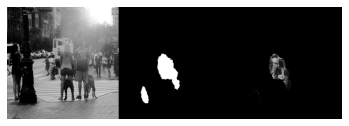

i= 27 loss= 0.1281367391347885 val_loss= 0.13203372061252594 mean_iou= 0.397396981716156 val_mean_iou= 0.3680324852466583


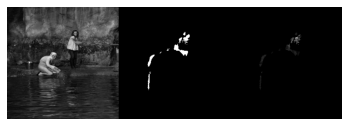

i= 28 loss= 0.12592624127864838 val_loss= 0.22199854254722595 mean_iou= 0.40211230516433716 val_mean_iou= 0.2378738820552826


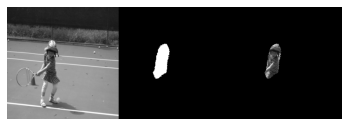

i= 29 loss= 0.1214173436164856 val_loss= 0.15584750473499298 mean_iou= 0.43298354744911194 val_mean_iou= 0.39412951469421387


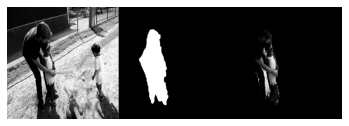

i= 30 loss= 0.12030548602342606 val_loss= 0.19639648497104645 mean_iou= 0.43002012372016907 val_mean_iou= 0.2614023685455322


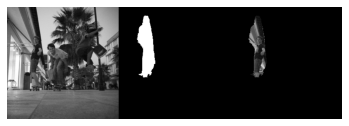

In [26]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

In [ ]:
 |  tf.__version__

'2.4.1'

In [29]:
import cv2
import numpy as np
a = Image.open('lena512.bmp').convert('L')
a = np.array(a.resize((256, 256)))
a = cv2.equalizeHist(a)
kernel = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
a = cv2.filter2D(a,-1,kernel)
b = np.stack((a,)*1, axis=-1)
b = a/255.
# b = tf.keras.preprocessing.image.img_to_array(a)
# b = np.array([b])
# b.shape

In [1]:
pred = model.predict(np.expand_dims(b,0))

msk = pred.squeeze()
msk.reshape(256,256)
msk[msk >= 0.5] = 1
msk[msk < 0.5] = 0

combined = np.concatenate([a, msk, a* msk], axis=1)
plt.axis('off')
plt.imshow(combined)

NameError: ignored

In [ ]:
  |

In [ ]:
|

In [ ]:
|